Bilder pro Sekunde
 ======
 
 Mit diesem Python Notebook ist es möglich, dass zeitliche Verhalten einer Serienaufnahme der Android Anwendung "Fahrradwege Monotring App" zu untersuchen.  
 Ziel ist es zu berechnen wie viele Bilder in einer Serienaufnahme pro Sekunde aufgenommen wurden.  
 Des Weiteren ist es möglich die längste Zeitspanne zwischen  zwei Aufnahmen innerhalb einer Serienaufnahme zu ermitteln.
 

Bilder pro Sekunde in einer Serienaufnahme

Um die Anzahl der Bilder pro Sekunde zu berechnen ist es wichtig, dass diese kontinuierlich in kurzen Zeitabschnitten  
aufgenommen wurden. In der Android habe ich einen Schwellenwert implementiert damit keine Aufnahmen gemacht werden,  
wenn eine bestimmte Geschwindikeit nicht überschritten wurde. Dies ist relevant um keine Aufnahme zu machen falls  
ein Fahrrad steht während die Anwendung läuft.

In [34]:
import pandas 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [35]:
# Startindex der Features eines Fotos   
startIndex = 0
# Stop Index 
stopIndex = 12000
# Öfnne die Datei features.csv. Der Path muss mit angegeben werden
featuresDf = pandas.read_csv(filepath_or_buffer="../merkmale.csv")

In [36]:
featuresDf.describe()

,Zeitstempel,Breitengrad,Laengengrad,Geschwindigkeit,Messwerte,StartBewegungsD,StartBelichtung,Belichtungszeit,MittelX,MittelY,...,VarianzX,VarianzY,VarianzZ,VarianzNick,VarianzRoll,AbweichungX,AbweichungY,AbweichungZ,AbweichungNick,AbweichungRoll
count,1.214900e+04,12149.000000,12149.000000,12149.000000,12149.0,1.214900e+04,1.214900e+04,1.214900e+04,12149.000000,12149.000000,...,12149.000000,12149.000000,12149.000000,12149.000000,12149.000000,12149.000000,12149.00000,12149.000000,12149.000000,12149.000000
mean,1.520521e+12,53.621404,10.175575,15.419228,20.0,3.972071e+12,3.972161e+12,1.931440e+07,0.001482,0.003506,...,2.121109,16.710875,17.784782,0.176490,0.252438,1.200596,3.22775,3.402667,0.380466,0.323835
std,1.226303e+06,0.006939,0.018062,3.447197,0.0,1.226303e+12,1.226303e+12,8.842717e+06,0.279567,0.564297,...,4.805029,37.120677,34.064271,0.165855,0.595264,0.824460,2.50859,2.491415,0.178153,0.384162
min,1.520519e+12,53.610477,10.137807,5.004000,20.0,1.618455e+12,1.618559e+12,4.127597e+06,-2.285901,-4.989452,...,0.000370,0.000230,0.000380,0.000000,0.000010,0.019240,0.01517,0.019490,0.000000,0.003160
25%,1.520520e+12,53.614110,10.161995,13.608000,20.0,2.973751e+12,2.973839e+12,1.000184e+07,-0.141578,-0.247978,...,0.515670,3.221720,3.578670,0.059210,0.011630,0.718100,1.79492,1.891740,0.243330,0.107840
50%,1.520521e+12,53.621760,10.177186,15.804000,20.0,3.963729e+12,3.963809e+12,2.000368e+07,0.000789,-0.004989,...,0.937230,6.096390,6.850140,0.114540,0.025740,0.968110,2.46909,2.617280,0.338440,0.160440
75%,1.520523e+12,53.627620,10.190325,17.712000,20.0,4.998830e+12,4.998939e+12,2.999632e+07,0.140186,0.253781,...,1.950760,13.289150,15.018690,0.240750,0.099260,1.396700,3.64543,3.875400,0.490660,0.315060
max,1.520523e+12,53.635113,10.203202,24.984000,20.0,5.977850e+12,5.977940e+12,2.999632e+07,2.644231,5.218423,...,144.743590,502.054320,575.782600,1.071350,5.731200,12.030940,22.40657,23.995470,1.035060,2.393990


In [37]:
# Andzahl der Einträge
featuresDf.index

RangeIndex(start=0, stop=12149, step=1)

In [38]:
# Namen der Spalten 
featuresDf.columns

Index(['Zeitstempel', 'Breitengrad', 'Laengengrad', 'Geschwindigkeit',
       'AccelerometerX', 'AccelerometerY', 'AccelerometerZ', 'Azimuth', 'Nick',
       'Roll', 'SensorZeitstempel', 'Messwerte', 'StartBewegungsD',
       'StartBelichtung', 'Belichtungszeit', 'MittelX', 'MittelY', 'MittelZ',
       'MittelNick', 'MittelRoll', 'AzimuthAenderung', 'VarianzX', 'VarianzY',
       'VarianzZ', 'VarianzNick', 'VarianzRoll', 'AbweichungX', 'AbweichungY',
       'AbweichungZ', 'AbweichungNick', 'AbweichungRoll'],
      dtype='object')

In [39]:
# Für den Plot der Bilder pro Sekunde 
imagesPerSecondList = []
imagesCaptured = []
tempTimeSum = 0
tempImages = 0
tempMs = featuresDf.iat[startIndex,0]

In [40]:
featuresDf.iat[i,0]

1520520864420

In [49]:
i = startIndex
firstMs = featuresDf.iat[i,0]
lastValueMs = firstMs
valueMs = 0
# Zeitliche Differenz zwischen zwei Aufnahmen
differenceValueTemp = 0
# Max Differenz, welche unter der variablen thresholdMax liegt 
maxDifference = 0
# Index mit der maxDifference
maxDifferenceIndex = 0
# Maximale gültige Zeit zwischen zwei Bildern in ms 
thresholdMax = 5000000000000000000000000000000000
# Das erste Bild wird nicht mit einbezogen in die Berechnung
imageCounter = -1
sum = 0
while i <= stopIndex:
    valueMs = featuresDf.iat[i,0]
    differenceValueTemp = valueMs - lastValueMs
    if differenceValueTemp > thresholdMax:  # Wenn Schwellwert zwischen zwei Bildern überschritten ist, ..
        break                                   # dann breche Schleife ab.
    if differenceValueTemp > maxDifference:
        maxDifference = differenceValueTemp
        maxDifferenceIndex = i
    sum =+ (featuresDf.iat[i,0] - firstMs)
    tempTimeSum =+ (featuresDf.iat[i,0] - tempMs)
    i =  i + 1
    imageCounter = imageCounter + 1
    if (tempImages % 100 == 0) & (imageCounter >= 100):   # Bei 100 Bildern wird die Geschwindikeit in einer Liste gespeichert
        imagesPerSecondList.append(tempImages/(tempTimeSum/1000)) # Anzahl der aufgenommenen Bilder durch vergangene Sekunden 
        imagesCaptured.append(imageCounter)
        tempTimeSum = 0
        tempImages = 0
        tempMs = featuresDf.iat[i,0]
    tempImages = tempImages + 1
    lastValueMs = valueMs

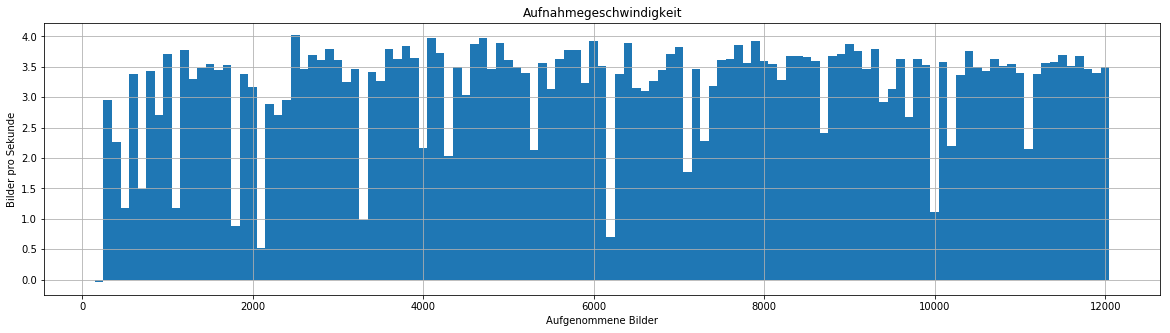

Maximale Bilder pro Sekunde: 4.01767778224


In [50]:
# Für 100 Bilder wird je ein Datenpunkt geplotet mit der Aufnahmegeschwindigkeit 
fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(imagesCaptured, imagesPerSecondList,100) #  tick_label=imagesCaptured / für schönere plots, wenn Anzahl der Bilder klein
ax.set(xlabel='Aufgenommene Bilder', ylabel='Bilder pro Sekunde',
       title='Aufnahmegeschwindigkeit')
ax.grid()
fig.savefig("bilderProSekunde.png")
plt.show()
print('Maximale Bilder pro Sekunde: ' + str(max(imagesPerSecondList)))

In [51]:
# Elemente aus Listen entfernen
imagesPerSecondList.clear()
imagesCaptured.clear()

In [52]:
meanMs = sum/imageCounter
imagesPerSecond = imageCounter/(sum/1000)

In [53]:
imagesPerSecond

2.7782138029996375

In [54]:
# Zeitliche nformationen über die gesamten Bilder
print("Anzahl der Bilder: " + str(imageCounter) + "\n" +
    "Mittelwert: " + str(meanMs) + "ms pro Aufnahme" + "\n" +
    "Bilder pro Sekunde: " + str(imagesPerSecond) + "\n" +
     "Maximale gültige Zeitdifferenz zwischen zwei Aufnahmen: " + str(maxDifference) +  "ms" + 
     " (Bild Nr.: " + str(maxDifferenceIndex) + ")" )

Anzahl der Bilder: 12000
Mittelwert: 359.9435ms pro Aufnahme
Bilder pro Sekunde: 2.778213803
Maximale gültige Zeitdifferenz zwischen zwei Aufnahmen: 156985ms (Bild Nr.: 2000)
